In [1]:
%pip install pandas numpy matplotlib scikit-learn scipy pymoo seaborn forestci 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Introduction
 This code is part of a broader research project on surrogate modeling for multi-objective variability estimation. In this version, we implement a non-parametric surrogate based on a Radial Basis Function combined with Inverse Distance Weighting (RBF-IDW). This approach is inspired by [1]. It implements a pipeline to train and iteratively refine a surrogate model—specifically,a Radial Basis Function combined with Inverse Distance Weighting (RBF-IDW).

[1] Y. Liu, H. Fang and F. Li, "An Expensive Multi-Objective Evolutionary Algorithm with RBF-IDW Surrogate Model," 2024 International Conference on New Trends in Computational Intelligence (NTCI), Qingdao, China, 2024, pp. 86-90, doi: 10.1109/NTCI64025.2024.10776091.

In [ ]:
import numpy as np
from pymoo.problems.many import DTLZ2
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize
# Step 1 :Problem Definition
# Define the multi-objective benchmark problem DTLZ2.
n_obj = 3
k = 20
n_vars = n_obj + k - 1
problem = DTLZ2(n_var=n_vars, n_obj=n_obj)

# Define scalarized objective function based on user preference vector λ
def scalarized_objective(x, lam, problem):
    f = problem.evaluate(np.array([x]))[0]
    return np.dot(lam, f)

def load_and_prepare(dataset_path):
    df = pd.read_csv(dataset_path).dropna(subset=["frob_norm"])
    X = df[["lambda_1", "lambda_2", "lambda_3"]].values
    y = df["frob_norm"].values.reshape(-1, 1)
    return df, X, y

def stratified_split(X, y, n_bins=10, test_size=0.2, random_state=42):
    y_bins = pd.qcut(y.ravel(), q=n_bins, duplicates='drop', labels=False)
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(splitter.split(X, y_bins))
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

def build_rbf_idw(X_train, y_train):
    def model(X_query, p=2, epsilon=1e-8):
        distances = cdist(X_query, X_train) + epsilon
        weights = 1.0 / np.power(distances, p)
        weights /= np.sum(weights, axis=1, keepdims=True)
        return np.dot(weights, y_train)
    return model


In [15]:
#  Uncertainty for new λ candidates is estimated as the mean distance to the k-nearest λs in the training set.
def expected_uncertainty_rbf(X_train, X_query, k=5):
    distances = cdist(X_query, X_train)
    nearest_dists = np.sort(distances, axis=1)[:, :k]  # k nearest distances
    uncertainty = np.mean(nearest_dists, axis=1)
    return uncertainty

In [16]:
# Step 4: Active Sampling via Uncertainty
# λ vectors with the highest uncertainty are selected for evaluation.

def select_uncertain_lambdas(dataset_path, n_samples=1000, top_k=10):
    df = pd.read_csv(dataset_path)
    X = df[[col for col in df.columns if col.startswith("lambda_")]].values
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)

    # Candidate λ generation
    candidates = np.random.dirichlet(np.ones(3), size=n_samples)
    candidates_scaled = scaler.transform(candidates)

    # Compute uncertainty
    uncertainties = expected_uncertainty_rbf(X_scaled, candidates_scaled, k=5)
    top_indices = np.argsort(-uncertainties)[:top_k]

    selected_lambdas = candidates[top_indices]
    print("\nTop λ selected with highest uncertainty:")
    print(selected_lambdas)
    return selected_lambdas


def active_learning_with_rbf(model, lambda_grid, df, X_scaler, y_scaler, top_k=10):
    X_candidates = X_scaler.transform(lambda_grid)
    preds = model(X_candidates)
    uncertainty = np.std(preds)
    scores = preds.ravel() + 0.1 * np.random.rand(len(preds)) + 0.5 * uncertainty
    top_indices = np.argsort(-scores)[:top_k]
    lambda_selected = lambda_grid[top_indices]

    # Calcolo nuove x_star e frob_norm
    new_x_star, frob_norms = [], []
    for lam in lambda_selected:
        res = minimize(scalarized_objective, x0=np.full(n_vars, 0.5), args=(lam, problem), method='L-BFGS-B', bounds=[(0.0, 1.0)] * n_vars)
        x_opt = res.x
        new_x_star.append(x_opt)
        frob = np.linalg.norm(np.cov(StandardScaler().fit_transform(np.array([x_opt])).T), ord='fro')
        frob_norms.append(frob)

    new_df = pd.DataFrame({
        "lambda_1": lambda_selected[:, 0],
        "lambda_2": lambda_selected[:, 1],
        "lambda_3": lambda_selected[:, 2],
        "frob_norm": frob_norms
    })
    df = pd.concat([df, new_df], ignore_index=True)
    return df 



In [17]:
# Step 5: Update Dataset with new data
# Implement an iterative update of the RBF-IDW model with new candidate solutions selected via Expected Uncertainty.
def update_rbf_with_new_data(lambda_selected, dataset_path, problem, window_size=10):
    dataset = pd.read_csv(dataset_path)
    n_vars = len([col for col in dataset.columns if col.startswith("x_star_")])
    n_obj = len([col for col in dataset.columns if col.startswith("lambda_")])

    new_x_star, new_frob_norms, new_variances, new_P_vectors = [], [], [], []
    for lam in lambda_selected:
        res = minimize(scalarized_objective, x0=np.full(n_vars, 0.5), args=(lam, problem), method='L-BFGS-B', bounds=[(0.0, 1.0)] * n_vars)
        x_opt = res.x
        new_x_star.append(x_opt)

        if len(new_x_star) >= 2:
            X_local = StandardScaler().fit_transform(np.array(new_x_star[-window_size:]))
            C = np.cov(X_local.T) + np.eye(n_vars) * 1e-8
            new_frob_norms.append(np.linalg.norm(C, ord='fro'))
            new_variances.append(np.var(X_local, axis=0))
            P = np.linalg.cholesky(C)
            new_P_vectors.append(P[np.tril_indices_from(P)])
        else:
            new_frob_norms.append(np.nan)
            new_variances.append(np.full(n_vars, np.nan))
            new_P_vectors.append(np.full((n_vars * (n_vars + 1)) // 2, np.nan))

    new_data_dict = {f"lambda_{i+1}": lambda_selected[:, i] for i in range(n_obj)}
    new_data_dict["frob_norm"] = new_frob_norms
    for i in range(n_vars):
        new_data_dict[f"x_star_{i+1}"] = [x[i] for x in new_x_star]
        new_data_dict[f"var_x_star_{i+1}"] = [v[i] for v in new_variances]
    for i in range(len(new_P_vectors[0])):
        new_data_dict[f"P_vec_{i+1}"] = [p[i] for p in new_P_vectors]
    new_data_dict["source"] = ["EI_selected"] * len(lambda_selected)

    new_df = pd.DataFrame(new_data_dict)
    updated_dataset = pd.concat([dataset, new_df], ignore_index=True).dropna(subset=["frob_norm"])
    updated_dataset.to_csv(dataset_path, index=False)

    X = updated_dataset[[f"lambda_{i+1}" for i in range(n_obj)]].values
    y = updated_dataset["frob_norm"].values.reshape(-1, 1)

    X_scaler = StandardScaler().fit(X)
    y_scaler = StandardScaler().fit(y)
    X_scaled = X_scaler.transform(X)
    y_scaled = y_scaler.transform(y).ravel()

    split = int(0.8 * len(X_scaled))
    X_train, X_test = X_scaled[:split], X_scaled[split:]
    y_train, y_test = y_scaled[:split], y_scaled[split:]

    def rbf_idw_predict(X_train, y_train, X_query, p=2, epsilon=1e-8):
        distances = cdist(X_query, X_train) + epsilon
        weights = 1.0 / np.power(distances, p)
        weights /= np.sum(weights, axis=1, keepdims=True)
        return np.dot(weights, y_train)

    y_pred_scaled = rbf_idw_predict(X_train, y_train, X_test)
    y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
    y_pred_inv = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    print("[RBF-IDW Surrogate Performance - Updated]")
    print("RMSE:", np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
    print("R2:", r2_score(y_test_inv, y_pred_inv))

    plt.figure(figsize=(7, 6))
    plt.scatter(y_test_inv, y_pred_inv, alpha=0.7)
    plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'r--')
    plt.title("RBF-IDW Prediction vs True ‖C(λ)‖_F")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return updated_dataset


In [18]:
# Function: compute Frobenius norm of covariance over lambda-local neighbors
# This is used to estimate local structural variability of optimal solutions in the vicinity of the current lambda.
# It helps to ensure more stable and generalizable surrogate predictions.
def compute_local_covariance(x_stars, lambdas, current_lambda, k_neighbors=5):
    if len(x_stars) < k_neighbors:
        k_neighbors = len(x_stars)
    dists = np.linalg.norm(lambdas - current_lambda, axis=1)
    idx = np.argsort(dists)[:k_neighbors]
    X_local = StandardScaler().fit_transform(x_stars[idx])
    C = np.cov(X_local.T) + np.eye(X_local.shape[1]) * 1e-8
    return np.linalg.norm(C, ord='fro'), np.var(X_local, axis=0), C



In [ ]:
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2



>>> Iteration 1/3
  -> Training RBF-IDW surrogate...
[Evaluation] RMSE = 0.1996, R2 = 0.6708


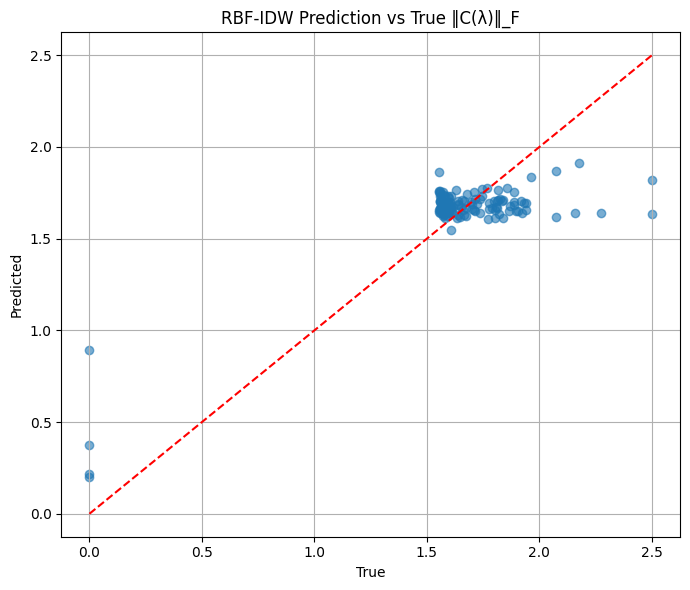


Top λ selected with highest uncertainty:
[[0.13451063 0.24755703 0.61793234]
 [0.00255819 0.37932017 0.61812165]
 [0.07996799 0.82748874 0.09254327]
 [0.08863722 0.79613183 0.11523095]
 [0.07757898 0.83581153 0.08660949]
 [0.08597741 0.81066758 0.10335501]
 [0.09872768 0.80867167 0.09260065]
 [0.27332893 0.69445498 0.03221609]
 [0.14718028 0.23991624 0.61290347]
 [0.00450673 0.36656305 0.62893022]]


C:\Users\aless\AppData\Local\Temp\ipykernel_10620\1846376446.py:38: RuntimeWarning: Degrees of freedom <= 0 for slice
  frob = np.linalg.norm(np.cov(StandardScaler().fit_transform(np.array([x_opt])).T), ord='fro')
c:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\aless\AppData\Local\Temp\ipykernel_10620\1846376446.py:38: RuntimeWarning: Degrees of freedom <= 0 for slice
  frob = np.linalg.norm(np.cov(StandardScaler().fit_transform(np.array([x_opt])).T), ord='fro')
c:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\aless\Desk

[RBF-IDW Surrogate Performance - Updated]
RMSE: 0.5905631128772713
R2: -0.02034368936080866


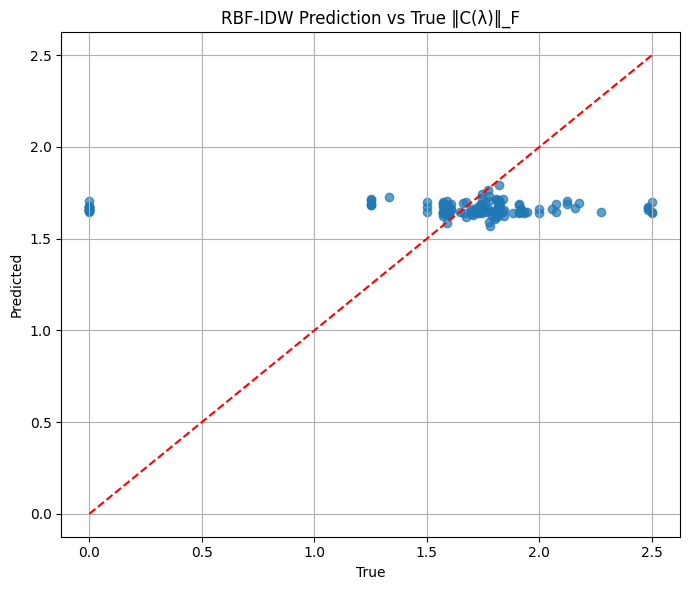


>>> Iteration 2/3
  -> Training RBF-IDW surrogate...
[Evaluation] RMSE = 0.1812, R2 = 0.6469


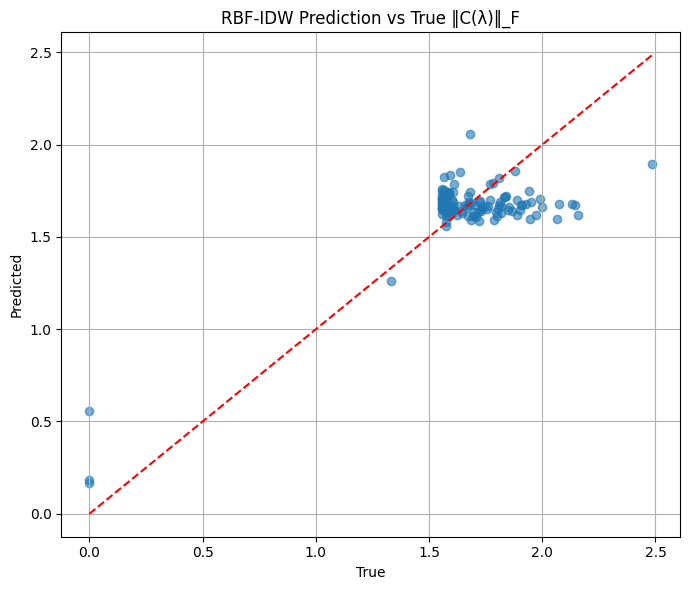


Top λ selected with highest uncertainty:
[[0.28470276 0.71144259 0.00385464]
 [0.2911805  0.69983363 0.00898587]
 [0.09669947 0.10716194 0.79613859]
 [0.177185   0.81746618 0.00534882]
 [0.08507279 0.13041969 0.78450752]
 [0.17482273 0.81911696 0.00606031]
 [0.003813   0.22042519 0.77576181]
 [0.00756177 0.20251957 0.78991865]
 [0.18881709 0.80943425 0.00174866]
 [0.15642737 0.82883213 0.0147405 ]]


C:\Users\aless\AppData\Local\Temp\ipykernel_10620\1846376446.py:38: RuntimeWarning: Degrees of freedom <= 0 for slice
  frob = np.linalg.norm(np.cov(StandardScaler().fit_transform(np.array([x_opt])).T), ord='fro')
c:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\aless\AppData\Local\Temp\ipykernel_10620\1846376446.py:38: RuntimeWarning: Degrees of freedom <= 0 for slice
  frob = np.linalg.norm(np.cov(StandardScaler().fit_transform(np.array([x_opt])).T), ord='fro')
c:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\aless\Desk

[RBF-IDW Surrogate Performance - Updated]
RMSE: 0.6023792142792489
R2: -0.009096330622599957


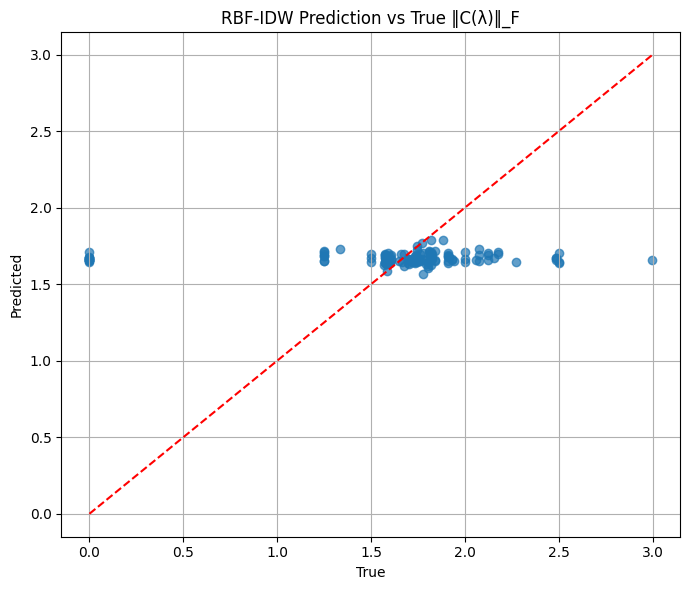


>>> Iteration 3/3
  -> Training RBF-IDW surrogate...
[Evaluation] RMSE = 0.2278, R2 = 0.5213


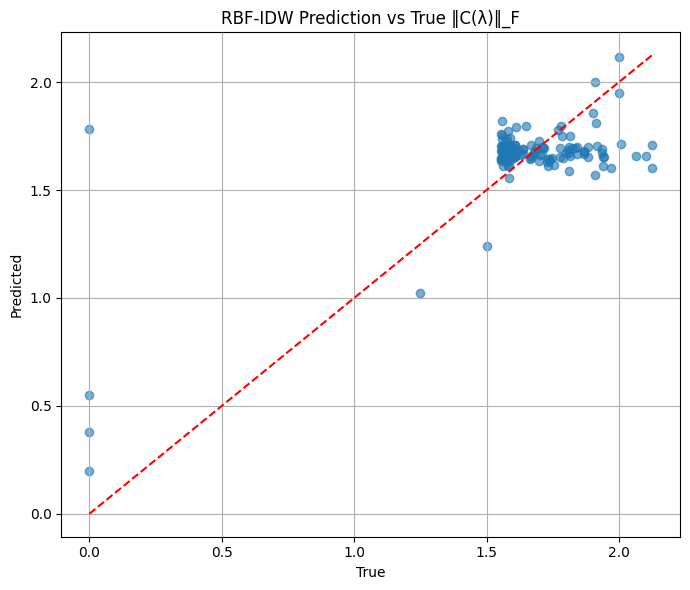


Top λ selected with highest uncertainty:
[[0.67347192 0.00318782 0.32334026]
 [0.00283671 0.82609608 0.17106721]
 [0.00215924 0.91233827 0.08550249]
 [0.899354   0.09756571 0.0030803 ]
 [0.8063229  0.17934171 0.01433539]
 [0.00877563 0.06860487 0.9226195 ]
 [0.00252386 0.84517425 0.15230189]
 [0.00682402 0.81274573 0.18043025]
 [0.68465086 0.14902428 0.16632485]
 [0.00290573 0.43643418 0.56066009]]


C:\Users\aless\AppData\Local\Temp\ipykernel_10620\1846376446.py:38: RuntimeWarning: Degrees of freedom <= 0 for slice
  frob = np.linalg.norm(np.cov(StandardScaler().fit_transform(np.array([x_opt])).T), ord='fro')
c:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\aless\AppData\Local\Temp\ipykernel_10620\1846376446.py:38: RuntimeWarning: Degrees of freedom <= 0 for slice
  frob = np.linalg.norm(np.cov(StandardScaler().fit_transform(np.array([x_opt])).T), ord='fro')
c:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\aless\Desk

[RBF-IDW Surrogate Performance - Updated]
RMSE: 0.6060631432772534
R2: -0.0014023010314190287


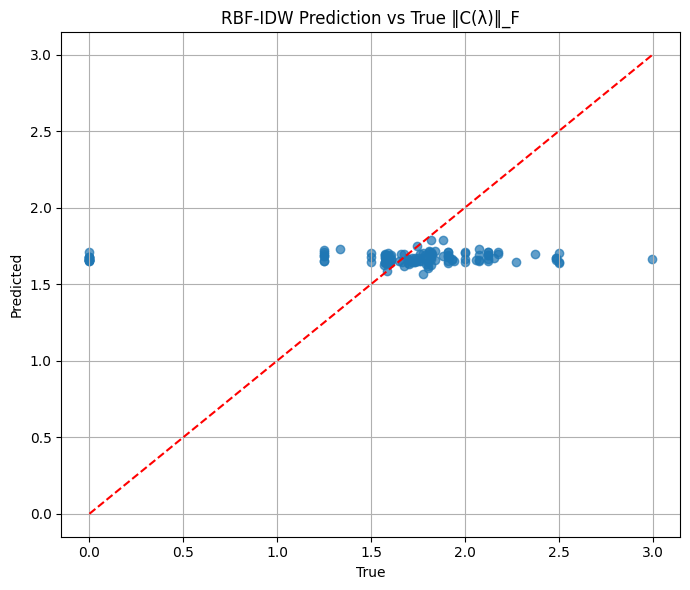


>>> Pipeline completata.


In [ ]:

def main_pipeline(dataset_path="dtlz2_dataset_balanced0.csv", n_iterations=3, top_k_ei=10, grid_step=0.05):
    df, X, y = load_and_prepare(dataset_path)
    
    for it in range(1, n_iterations + 1):
        print(f"\n>>> Iteration {it}/{n_iterations}")
        X_tr, X_te, y_tr, y_te = stratified_split(X, y, n_bins=10, test_size=0.2, random_state=42 + it)
        X_scaler = StandardScaler().fit(X_tr)
        y_scaler = StandardScaler().fit(y_tr)
        X_tr_s = X_scaler.transform(X_tr)
        X_te_s = X_scaler.transform(X_te)
        y_tr_s = y_scaler.transform(y_tr).ravel()
        y_te_s = y_scaler.transform(y_te).ravel()
        print("  -> Training RBF-IDW surrogate...")
        rbf_model = build_rbf_idw(X_tr_s, y_tr_s)
        y_pred = rbf_model(X_te_s)
        y_pred_inv = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
        y_te_inv = y_scaler.inverse_transform(y_te_s.reshape(-1, 1)).ravel()

        rmse, r2 = evaluate_model(y_te_inv, y_pred_inv)
        print(f"[Evaluation] RMSE = {rmse:.4f}, R2 = {r2:.4f}")
        
     
        lambda_selected = select_uncertain_lambdas(dataset_path)
        df = active_learning_with_rbf(rbf_model, lambda_selected, df, X_scaler, y_scaler, top_k=top_k_ei)
    
        
        df = update_rbf_with_new_data(
        lambda_selected=lambda_selected,
        dataset_path=dataset_path,
        problem=problem,
        window_size=5,
    )


        # 7) Ricostruisci X,y per la prossima it.
        X = df[["lambda_1","lambda_2","lambda_3"]].values
        y = df["frob_norm"].values.reshape(-1,1)

    print("\n>>> Pipeline completata.")

if __name__ == "__main__":
    main_pipeline(
        dataset_path="dtlz2_surrogate_dataset_extended_updated.csv",
        n_iterations=3,
        top_k_ei=10,
        grid_step=0.05
    )



